# 1. Exploration du dataset et data augmentation

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import albumentations as A
from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf
from PIL import Image


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-06-06 10:06:53.926843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749204414.228553      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749204414.309264      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def show_samples(dataset, class_names, num_samples=9):
        # On prend un batch pour extraire les premières images
        for images, labels in dataset.take(1):
            images = images.numpy()
            labels = labels.numpy()
            break
    
        # Nombre d’images à afficher
        n = min(num_samples, images.shape[0])
    
        # Calcul de la grille (carrée si possible)
        cols = int(tf.math.ceil(n**0.5))
        rows = int(tf.math.ceil(n / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
        axes = axes.flatten()
    
        for i in range(n):
            ax = axes[i]
            img = images[i]
            # On suppose img déjà normalisée en [0,1] pour l’affichage
            ax.imshow(img)
            ax.set_title(class_names[labels[i]])
            ax.axis('off')
    
        # Masquer les emplacements vides
        for j in range(n, len(axes)):
            axes[j].axis('off')
    
        plt.tight_layout()
        plt.show()

In [3]:
def make_dataset(paths, labels, transform, batch_size, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(paths), seed=42)

    def _load_and_transform(path, label):
        # path, label sont tf.Tensor scalar
        # on les convertit en NumPy via Albumentations
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3).numpy()     # uint8 H×W×3
        aug = transform(image=img)['image']                     # C×H×W tensor ou array
        # si ToTensorV2() → torch tensor ; convertir en numpy
        if hasattr(aug, 'numpy'):
            aug = aug.numpy()
        # on remet en H×W×C float32 [0–1]
        aug = aug.transpose(1,2,0).astype(np.float32)
        return aug, label

    def _transform_py(path, label):
        aug, lab = tf.py_function(
            _load_and_transform, [path, label], [tf.float32, tf.int32]
        )
        # **Ici on informe TF de la forme exacte** :
        aug.set_shape([TARGET_SIZE, TARGET_SIZE, 3])
        lab.set_shape([])  # label scalaire
        return aug, lab
    
    ds = ds.map(_transform_py, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [4]:
def load_image(img_path):
    img = cv2.imread(img_path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
def plot_image_and_histogram(img, title='Histogramme'):
    # Convertir en niveaux de gris
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

    plt.figure(figsize=(10, 4))

    # Affichage de l'image en niveaux de gris
    plt.subplot(1, 2, 1)
    plt.imshow(gray, cmap='gray')
    plt.title(title)
    plt.axis('off')

    # Affichage de l'histogramme en niveaux de gris
    plt.subplot(1, 2, 2)
    plt.plot(hist, color='black')
    plt.title('Histogramme (Niveaux de Gris)')
    plt.xlabel('Intensité')
    plt.ylabel('Nombre de pixels')
    plt.xlim([0, 256])

    plt.tight_layout()
    plt.show()

# Augmentations

def whitening_image(img):
    img = img.astype(np.float32)
    mean, std = img.mean(), img.std()
    img = (img - mean) / (std + 1e-5)
    img = np.clip((img - img.min()) / (img.max() - img.min()), 0, 1)
    return (img * 255).astype(np.uint8)

def change_contrast(img, alpha=1.5, beta=0):
    return cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

def equalize_image(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

def denoise_image(img):
    return cv2.medianBlur(img, 5)

In [5]:
def export_dataset_to_npz(dataset, chemin_fichier):
    """
    Parcourt tout le `dataset` (objets tf.data.Dataset ou DataLoader PyTorch),
    collecte les images et labels dans des listes, puis sauve en .npz.
    """
    all_images = []
    all_labels = []
    
    for batch in dataset:
        # Selon que vous soyez en TF ou en PyTorch, on récupère x et y différemment :
        if isinstance(batch, tuple) and len(batch) == 2:
            x_batch, y_batch = batch
        else:
            # Si votre DataLoader retourne (images, labels, autre_chose), ajustez ici
            raise ValueError("On attend des tuples (x, y).")
        
        # Conversion en NumPy :
        try:
            # TensorFlow : x_batch.numpy(), y_batch.numpy()
            imgs_np = x_batch.numpy()
            lbls_np = y_batch.numpy()
        except AttributeError:
            # PyTorch : x_batch est un torch.Tensor
            imgs_np = x_batch.detach().cpu().numpy()
            lbls_np = y_batch.detach().cpu().numpy()

        all_images.append(imgs_np)
        all_labels.append(lbls_np)

    # Concaténation en un seul grand tableau :
    X = np.concatenate(all_images, axis=0)
    y = np.concatenate(all_labels, axis=0)

    # Sauvegarde :
    np.savez(chemin_fichier, images=X, labels=y)
    print(f"Dataset exporté dans : {chemin_fichier}.npz")

## 2. 🔍 Exploration du dataset
### 2.1 Chargement des données

In [6]:
base_path = "/kaggle/input/stanford-dogs-dataset/Images"
races = sorted(os.listdir(base_path))
print(f"Nombre total de races : {len(races)}")


Nombre total de races : 120


In [7]:
image_paths_all = []
labels_all = []

for race in races:
    race_folder = os.path.join(base_path, race)
    race_images = glob(os.path.join(race_folder, "*.jpg"))
    image_paths_all.extend(race_images)
    labels_all.extend([race] * len(race_images))

print(f"Taille totale du dataset : {len(image_paths_all)}")

Taille totale du dataset : 20580


### 2.2 Distribution des images par race

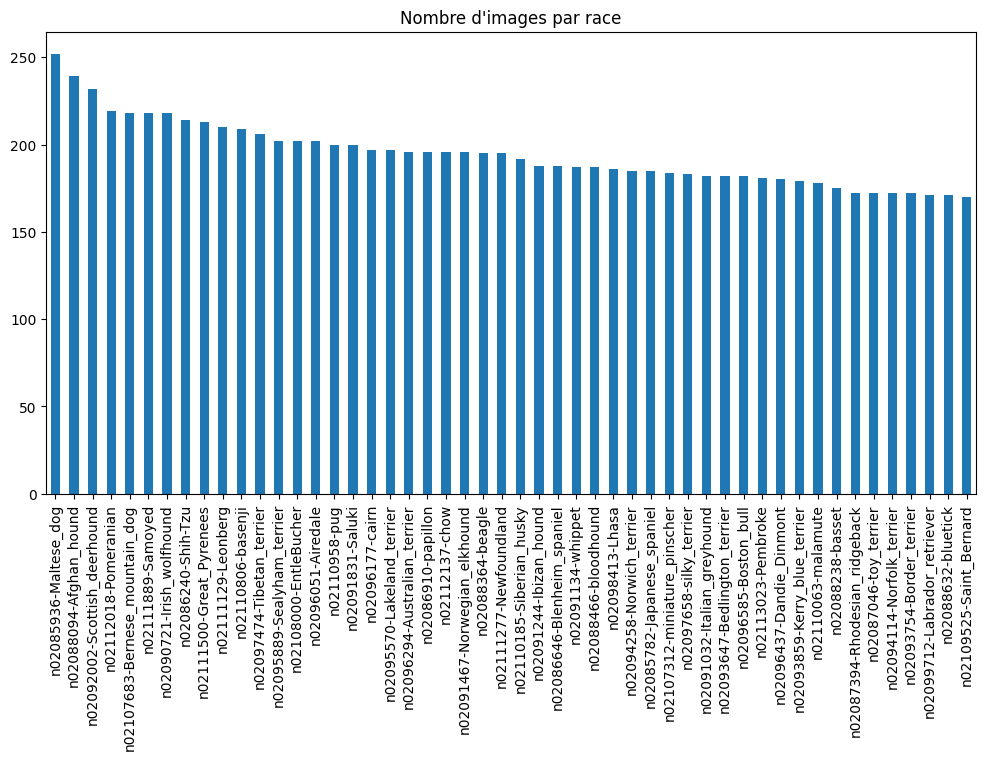

In [8]:
race_counts = pd.Series(labels_all).value_counts()
race_counts.head(50).plot(kind='bar', figsize=(12,6), title="Nombre d'images par race")
plt.xticks(rotation=90)
plt.show()


### 2.3 Taille des images

In [9]:
heights, widths = [], []
for path in image_paths_all:
    img = cv2.imread(path)
    if img is not None:
        h, w = img.shape[:2]
        heights.append(h)
        widths.append(w)

print(f"Taille moyenne : {np.mean(heights):.1f} x {np.mean(widths):.1f}")
print(f"Taille min : {np.min(heights)} x {np.min(widths)}")
print(f"Taille max : {np.max(heights)} x {np.max(widths)}")

Taille moyenne : 385.9 x 442.5
Taille min : 100 x 97
Taille max : 2562 x 3264


### 2.4 Exemples d’images

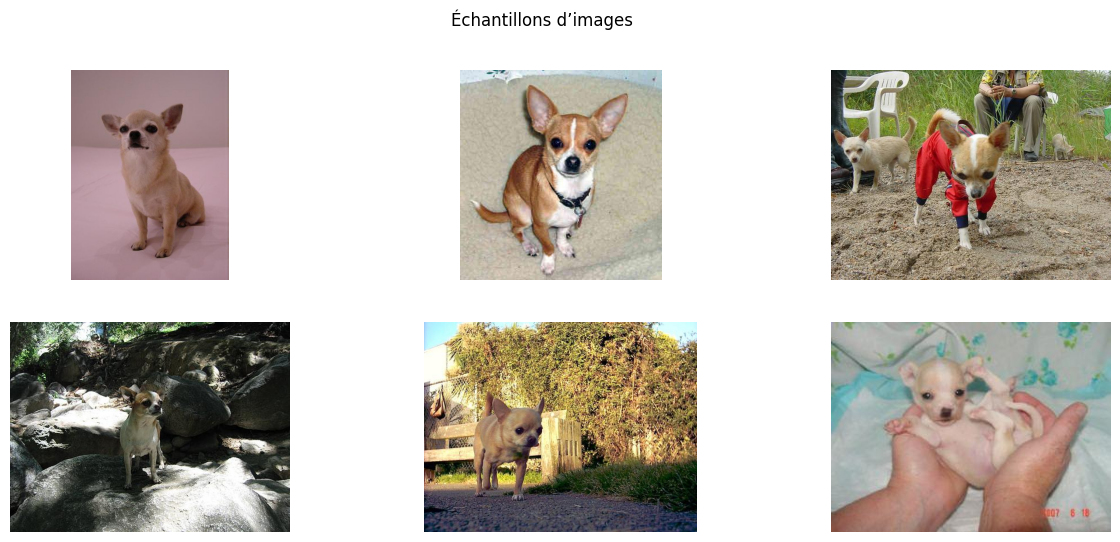

In [10]:
plt.figure(figsize=(15, 6))
for i, path in enumerate(image_paths_all[:6]):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Échantillons d’images")
plt.show()


## 3. 🧪 Prétraitements et augmentations

Pour chaque transformation ci-dessous, applique-la à une image test :
- Affiche l’image avant/après
- Affiche les histogrammes avant/après

In [11]:
crop_transform = A.Compose([
    A.CenterCrop(height=200, width=200, p=1.0),
])

flip_transform = A.Compose([
    A.HorizontalFlip(p=1.0),
])

whiten_transform = A.Lambda(image=whitening_image)

contrast_transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2,
                               contrast_limit=0.2,
                               p=1.0),
])

equalize_transform = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=1.0),
])

denoise_transform = A.Compose([
    A.MedianBlur(blur_limit=5, p=1.0),
])

### 🔄 3.1 Flip horizontal (mirroring)


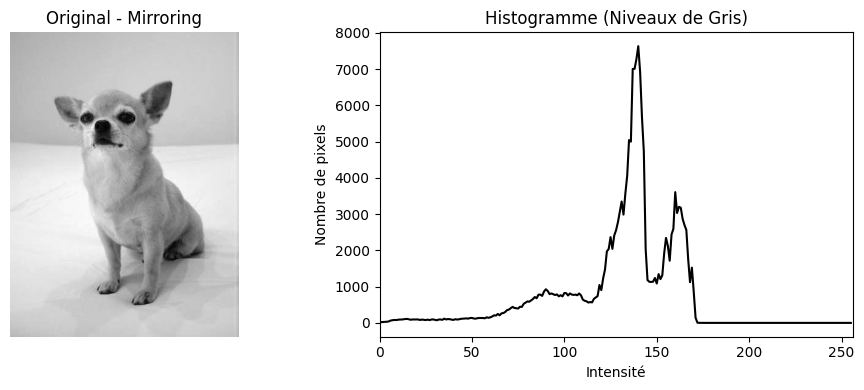

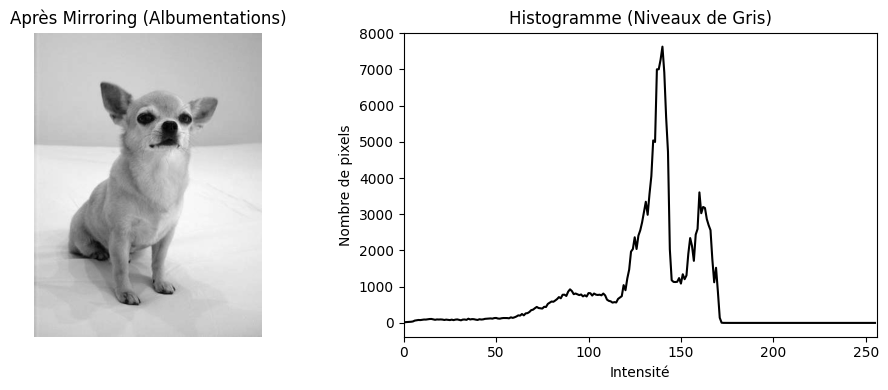

In [12]:
img = cv2.imread(image_paths_all[0])
mirrored = flip_transform(image=img)['image']

plot_image_and_histogram(img,    title='Original - Mirroring')
plot_image_and_histogram(mirrored, title='Après Mirroring (Albumentations)')

### ✂️ 3.2 Crop centré


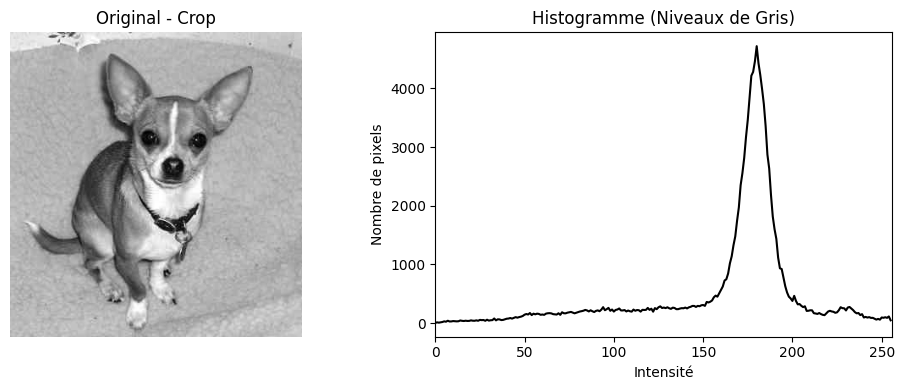

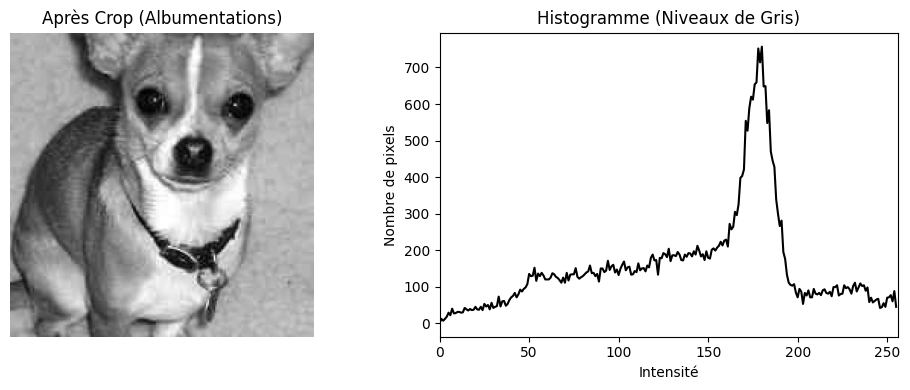

In [13]:
img = cv2.imread(image_paths_all[1])
cropped = crop_transform(image=img)['image']
plot_image_and_histogram(img, title='Original - Crop')
plot_image_and_histogram(cropped, title='Après Crop (Albumentations)')


### ⚪ 3.3 Whitening


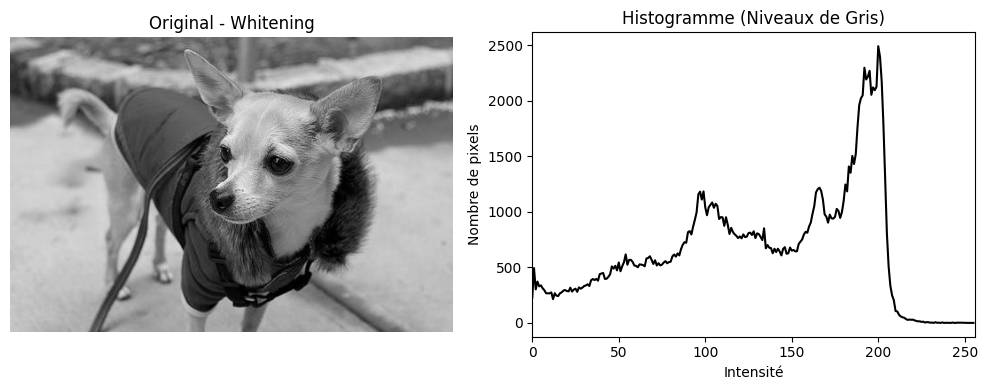

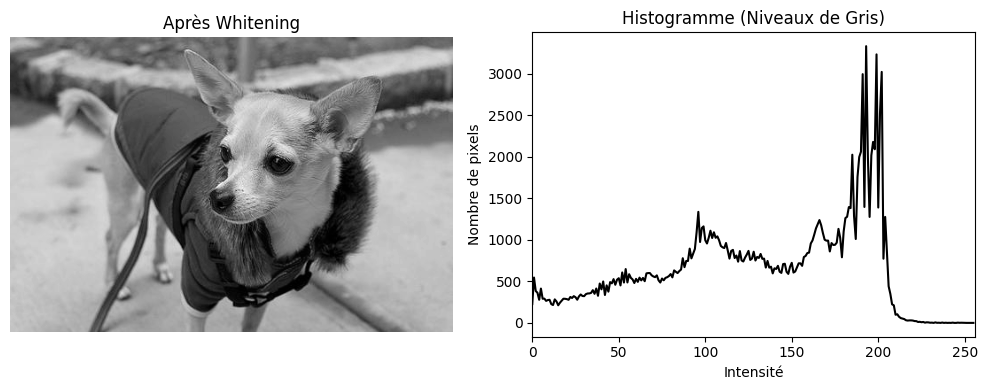

In [14]:
img = cv2.imread(image_paths_all[8])
whitened = whitening_image(img)

plot_image_and_histogram(img, title='Original - Whitening')
plot_image_and_histogram(whitened, title='Après Whitening')

### 🌗 3.4 Equalization


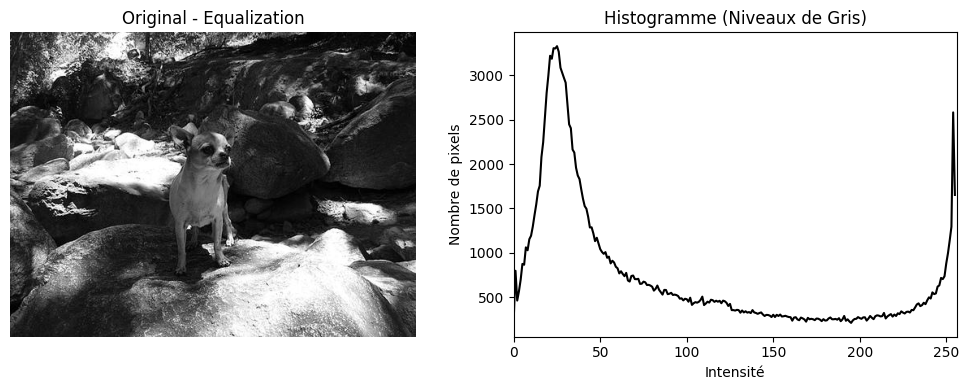

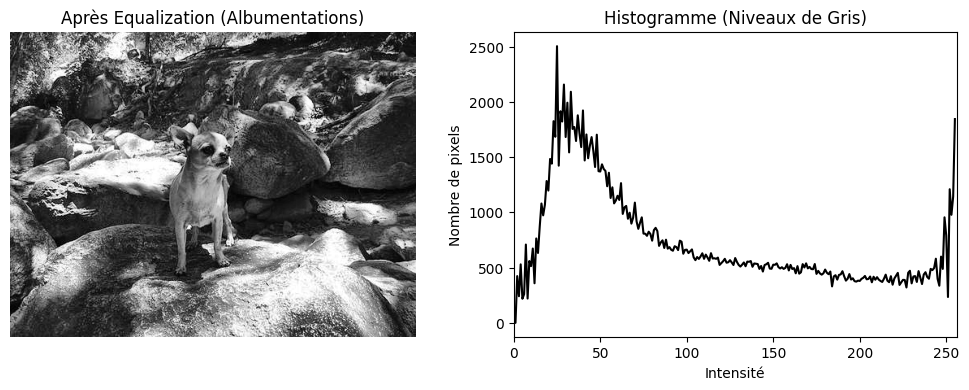

In [15]:
img = cv2.imread(image_paths_all[3])
equalized = equalize_transform(image=img)['image']
plot_image_and_histogram(img,         title='Original - Equalization')
plot_image_and_histogram(equalized, title='Après Equalization (Albumentations)')

### 🎚 3.5 Changement de contraste


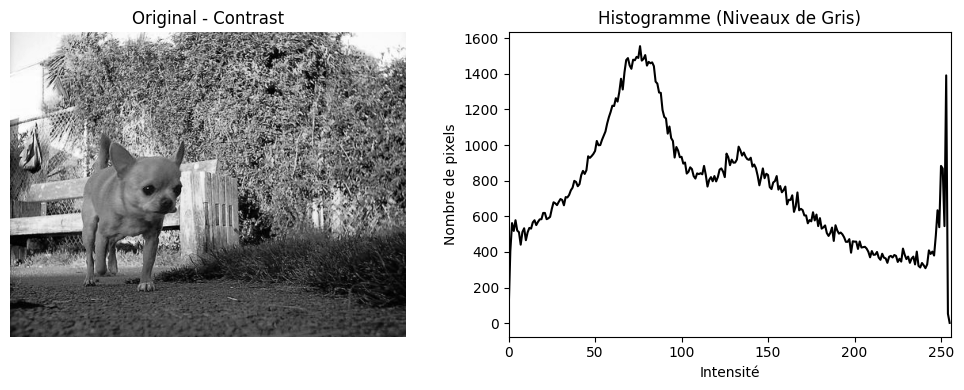

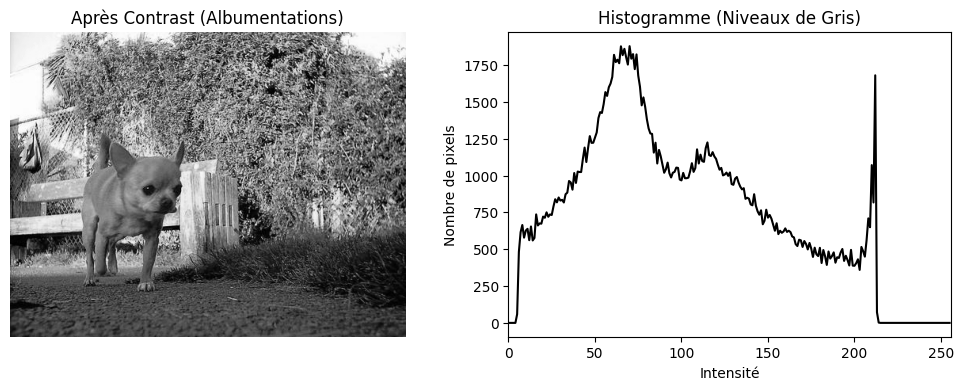

In [16]:
img = cv2.imread(image_paths_all[4])
contrasted = contrast_transform(image=img)['image']
plot_image_and_histogram(img,         title='Original - Contrast')
plot_image_and_histogram(contrasted, title='Après Contrast (Albumentations)')

### 🧼 3.6 Denoising


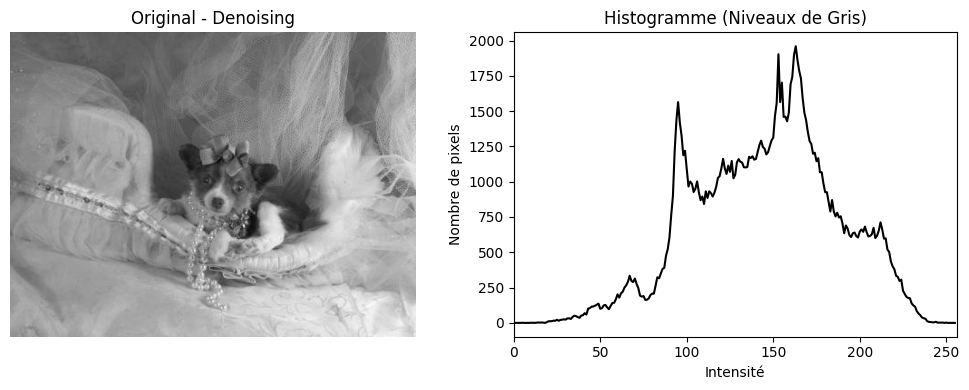

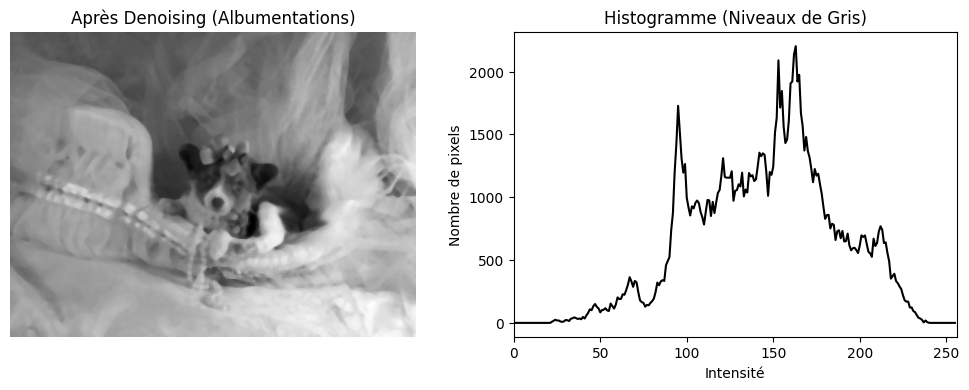

In [17]:
img = cv2.imread(image_paths_all[6])
denoised = denoise_transform(image=img)['image']
plot_image_and_histogram(img,        title='Original - Denoising')
plot_image_and_histogram(denoised, title='Après Denoising (Albumentations)')

## 4. Création et séparation des datasets

In [18]:
raw_dir = "/kaggle/input/stanford-dogs-dataset/Images"

# Comptage du nombre d'images par race
counts = {}
for breed in os.listdir(raw_dir):
    path = os.path.join(raw_dir, breed)
    if os.path.isdir(path):
        counts[breed] = len(os.listdir(path))

# On trie par fréquence et on garde les 10 premières
top10 = sorted(counts, key=counts.get, reverse=True)[:10]
print("Top 10 des races :", top10)

Top 10 des races : ['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound', 'n02112018-Pomeranian', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed', 'n02090721-Irish_wolfhound', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees', 'n02111129-Leonberg']


In [19]:
top10images = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)[:10]
for cls, cnt in top10images:
    print(f"{cls}: {cnt} images")

n02085936-Maltese_dog: 252 images
n02088094-Afghan_hound: 239 images
n02092002-Scottish_deerhound: 232 images
n02112018-Pomeranian: 219 images
n02107683-Bernese_mountain_dog: 218 images
n02111889-Samoyed: 218 images
n02090721-Irish_wolfhound: 218 images
n02086240-Shih-Tzu: 214 images
n02111500-Great_Pyrenees: 213 images
n02111129-Leonberg: 210 images


In [20]:
batch_size = 32
num_classes = len(top10)
TARGET_SIZE = 224

In [21]:
means, stds = [], []
for cls in top10:
    for fname in os.listdir(os.path.join(raw_dir, cls)):
        img = cv2.imread(os.path.join(raw_dir, cls, fname))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
        means.append(img.mean(axis=(0,1)))
        stds .append(img.std(axis=(0,1)))

dataset_mean = np.mean(means, axis=0)
dataset_std  = np.mean(stds,  axis=0)
print("Mean:", dataset_mean, "Std:", dataset_std)

Mean: [0.46580702 0.44905666 0.39209118] Std: [0.22929382 0.22483523 0.22733563]


In [22]:
train_transform = A.Compose([
    A.Resize(height=TARGET_SIZE, width=TARGET_SIZE, interpolation=cv2.INTER_LINEAR, p=1.0),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=1),    
    A.Normalize(mean=dataset_mean.tolist(), std=dataset_std.tolist()),
    
    A.ShiftScaleRotate(
    shift_limit=0.2,    # ±10% de décalage
    scale_limit=0.2,    # ±10% de zoom
    rotate_limit=40,    # ±20° de rotation
    p=0.7),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.MedianBlur(blur_limit=5, p=0.3),
    A.pytorch.transforms.ToTensorV2(),
])

# 1.2 Pipeline de validation (déterministe)
val_transform = A.Compose([
    A.Resize(height=TARGET_SIZE, width=TARGET_SIZE, interpolation=cv2.INTER_LINEAR, p=1.0),    
    A.Normalize(mean=dataset_mean.tolist(), std=dataset_std.tolist()),
    A.pytorch.transforms.ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(height=TARGET_SIZE, width=TARGET_SIZE, interpolation=cv2.INTER_LINEAR, p=1.0),
    A.Normalize(mean=dataset_mean.tolist(), std=dataset_std.tolist()),
    A.pytorch.transforms.ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [23]:
all_images, all_labels = [], []
class_to_idx = {cls_name: i for i, cls_name in enumerate(top10)}

means, stds = [], []
for cls_name in top10:
    folder = os.path.join(raw_dir, cls_name)
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        all_images.append(path)
        all_labels.append(class_to_idx[cls_name])

In [24]:
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    all_images, all_labels,
    test_size=0.2,
    stratify=all_labels,
    random_state=42
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels,
    test_size=0.25,
    stratify=train_val_labels,
    random_state=42
)

print(f"Train : {len(train_paths)} images")
print(f"Val   : {len(val_paths)} images")
print(f"Test  : {len(test_paths)} images")

Train : 1339 images
Val   : 447 images
Test  : 447 images


In [25]:
train_ds = make_dataset(train_paths, train_labels, train_transform, batch_size, shuffle=True)
val_ds   = make_dataset(val_paths,   val_labels,   val_transform,   batch_size, shuffle=False)
test_ds   = make_dataset(test_paths,   test_labels,   test_transform,   batch_size, shuffle=False)

2025-06-06 10:10:29.862357: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


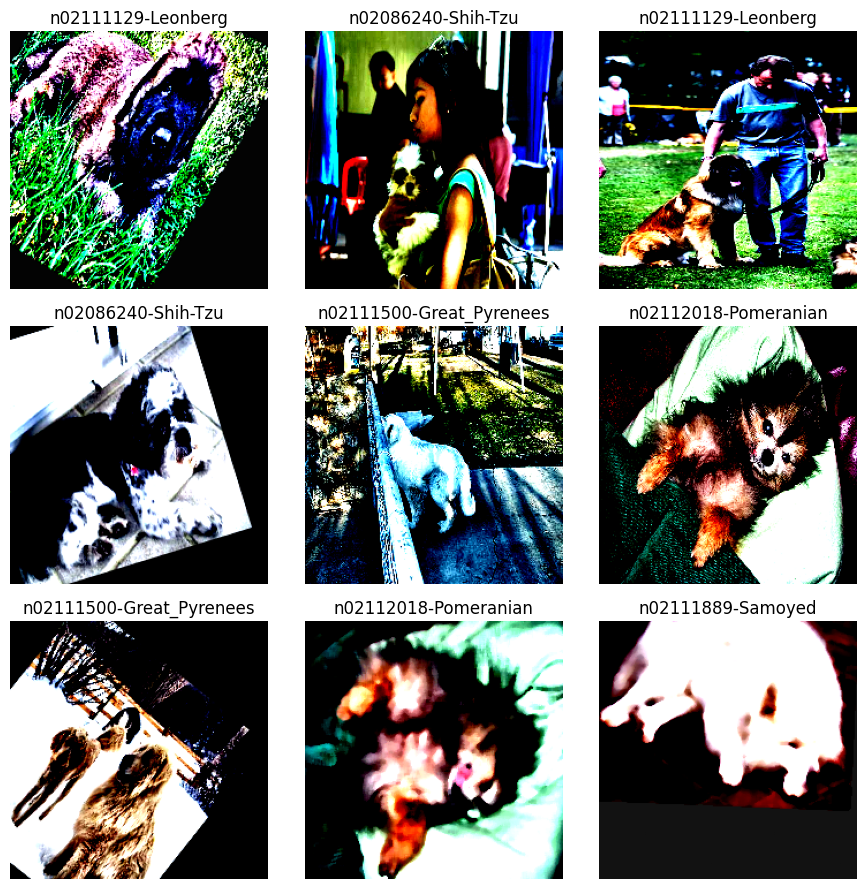

In [26]:
show_samples(train_ds, top10, 9)

In [27]:
def denormalize(img, mean, std):
    return img * std + mean

def export_test_images(dataset, folder, prefix, class_names=None, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    os.makedirs(folder, exist_ok=True)
    records = []

    idx = 0
    for batch_imgs, batch_labels in dataset:
        batch_imgs = batch_imgs.numpy()
        batch_labels = batch_labels.numpy()

        for img, label in zip(batch_imgs, batch_labels):
            # transpose (H, W, C) -> (C, H, W)
            img = img.transpose(2, 0, 1)

            # Dénormalisation
            mean_arr = np.array(mean).reshape(3, 1, 1)
            std_arr = np.array(std).reshape(3, 1, 1)
            img = denormalize(img, mean_arr, std_arr)
            img = np.clip(img, 0, 1)

            # back to (H, W, C)
            img = img.transpose(1, 2, 0)
            img_uint8 = (img * 255).astype(np.uint8)

            filename = f"{prefix}_{idx:05d}.jpg"
            filepath = os.path.join(folder, filename)

            Image.fromarray(img_uint8).save(filepath)

            label_str = class_names[label] if class_names is not None else str(label)
            records.append((filename, label_str))
            idx += 1

    df = pd.DataFrame(records, columns=["filename", "true_label"])
    df.to_csv(os.path.join(folder, f"{prefix}_labels.csv"), index=False)

    print(f"{idx} images exportées vers {folder}")
    
export_test_images(test_ds, folder="/kaggle/working/test_images", prefix="test", class_names=top10)

447 images exportées vers /kaggle/working/test_images


In [28]:
export_dataset_to_npz(train_ds, "/kaggle/working/train_data")
export_dataset_to_npz(val_ds,   "/kaggle/working/val_data")
export_dataset_to_npz(test_ds,  "/kaggle/working/test_data")

Dataset exporté dans : /kaggle/working/train_data.npz
Dataset exporté dans : /kaggle/working/val_data.npz
Dataset exporté dans : /kaggle/working/test_data.npz
